# Generative AI Text Summarization

In [1]:
# imports

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from openai import OpenAI
import os
from dotenv import load_dotenv
import s3fs
import fs_s3fs
import fsspec
import json
from llama_index.core import TreeIndex, SimpleDirectoryReader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
import keras
import transformers
import mlflow
import hyperopt as hp
import sphinx
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

C:\Users\nickr\OneDrive\Documents\GitHub\generative-ai-text-summarization\config\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# download stopwords

#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
newStopwords = ['b','lt','gt','n','u','ap','reuters'] # Add stopwords 

for stopword in newStopwords:
    stopwords.append(stopword)

In [ ]:
stopwords

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# Download dataset from Kaggle

dataset = "https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/data"
od.download(dataset)

In [64]:
# Read dataset, import only 30000 rows of data

df = pd.read_csv(r'C:\Users\nickr\OneDrive\Documents\GitHub\generative-ai-text-summarization\data\ag-news-classification-dataset\ag_news.csv',nrows=30000)

In [65]:
# Check shape of dataframe

df.shape

(30000, 3)

In [66]:
# Confirm importation

df.head(8)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...


# Data Cleaning and Preprocessing

In [ ]:
# find null values and datatypes

df.info(memory_usage='deep')

There are no null values in the df_train dataset.

In [ ]:
# check for duplicates

df.duplicated().sum()

There are no duplicate values in the df_train dataset.

In [67]:
# Cleaning data set html, special, and non-textual characters

def cleaning_text(text):
    # Remove HTML tags
    cleaning_text = re.sub('<.*?>', '', text)
    # Remove special characters and non-textual 
    cleaning_text = re.sub(r'([^a-zA-Z\s]|\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', ' ', cleaning_text) # checks plain text for given characters
    return cleaning_text

In [68]:
# apply text cleaning to text in both Description and Title

df['Title'] = df['Title'].apply(cleaning_text)

In [69]:
# Check that the function worked

df.head(7)

,Class Index,Title,Description
0,3,Wall St Bears Claw Back Into the Black Reuters,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks Outlook Reuters,Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,Oil prices soar to all time record posing new...,"AFP - Tearaway world oil prices, toppling reco..."
5,3,Stocks End Up But Near Year Lows Reuters,Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week AP,AP - Assets of the nation's retail money marke...


Note that in this data set, 1 represents World News, 2 represents Sports News, 3 represents Business News, and 4 represents Sci/Tech news

In [70]:
# Create a function to remove stop words

stop_words = set(stopwords)
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
    tokens = [word for word in tokens if word not in stop_words]  # Stop word removal
    return ' '.join(tokens)

In [71]:
# apply preprocessing to text in Title

df['Title'] = df['Title'].apply(preprocess_text)

In [10]:
# Check that the function worked

df.head(7)

,Class Index,Title,Description
0,3,wall st bears claw back black reuters,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,carlyle looks toward commercial aerospace reuters,Reuters - Private investment firm Carlyle Grou...
2,3,oil economy cloud stocks outlook reuters,Reuters - Soaring crude prices plus worries\ab...
3,3,iraq halts oil exports main southern pipeline ...,Reuters - Authorities have halted oil export\f...
4,3,oil prices soar time record posing new menace ...,"AFP - Tearaway world oil prices, toppling reco..."
5,3,stocks end near year lows reuters,Reuters - Stocks ended slightly higher on Frid...
6,3,money funds fell latest week ap,AP - Assets of the nation's retail money marke...


In [ ]:
# convert to CSV for ease of use in future

cleaned_data_file = r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned\cleaned_ag_news.csv'
df.to_csv(cleaned_data_file, index=False)

# Data Splitting

In [75]:
# Split training data into training and validation data 

df_train, df_test = train_test_split(df, test_size=.15, random_state=42)

In [ ]:
# Create csv file for train and test data

df_train.to_csv(os.path.join(r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned', 'train.csv'), index=False)
df_test.to_csv(os.path.join(r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned', 'test.csv'), index=False)

In [ ]:
# Create feature data directory

feature_data_dir = r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\features'
os.makedirs(feature_data_dir, exist_ok=True)

In [76]:
# TF-IDF Vectorization for Title

tfidf_vectorizer = TfidfVectorizer(max_features=3000)  # we can play around with this. This was an arbitrary value
train_title_features = tfidf_vectorizer.fit_transform(df_train['Title'])
test_title_features = tfidf_vectorizer.transform(df_test['Title'])

In [ ]:
# look at one of the matrices the vectorizer produces

# print(df_train['Title'][98])
# print(train_title_features.toarray()[98]) 

Note, the vectorizer produces a value for a specific word on a scale of 0 to 1. The closer the number is to 1, the more unique that word is.

In [77]:
# Print our features

features = tfidf_vectorizer.get_feature_names_out()
print(tfidf_vectorizer.vocabulary_, end=' ')

{'tennis': 2659, 'agassi': 38, 'goes': 1114, 'google': 1122, 'still': 2535, 'last': 1456, 'digital': 720, 'radio': 2082, 'new': 1736, 'front': 1055, 'piracy': 1912, 'war': 2891, 'sony': 2463, 'group': 1142, 'agrees': 45, 'buy': 354, 'mgm': 1619, 'toys': 2730, 'wireless': 2945, 'crowd': 611, 'join': 1386, 'nikkei': 1748, 'average': 178, 'update': 2809, 'nd': 1718, 'shows': 2393, 'request': 2168, 'issue': 1358, 'drops': 782, 'israel': 1355, 'build': 344, 'housing': 1252, 'units': 2803, 'profits': 2022, 'rise': 2207, 'retail': 2182, 'un': 2794, 'staff': 2505, 'call': 365, 'afghan': 32, 'pullout': 2044, 'singh': 2414, 'could': 580, 'woods': 2956, 'chechen': 445, 'story': 2546, 'leader': 1474, 'terror': 2663, 'russia': 2250, 'woodward': 2957, 'lions': 1513, 'coach': 504, 'internet': 1330, 'turns': 2780, 'work': 2959, 'progress': 2025, 'taken': 2625, 'along': 71, 'issues': 1359, 'finally': 966, 'comes': 521, 'age': 39, 'athens': 156, 'van': 2835, 'continues': 561, 'cassini': 406, 'discovers'

In [ ]:
# Confirm feature number

print(len(features))

In [ ]:
# Save the TF-IDF feature matrices

#pd.DataFrame(train_desc_features.toarray()).to_csv(os.path.join(feature_data_dir, 'train_desc_features.csv'), index=False)
#pd.DataFrame(test_desc_features.toarray()).to_csv(os.path.join(feature_data_dir, 'test_desc_featuress.csv'), index=False)
#pd.DataFrame(train_title_features.toarray()).to_csv(os.path.join(feature_data_dir, 'train_title_features.csv'), index=False)
#pd.DataFrame(test_title_features.toarray()).to_csv(os.path.join(feature_data_dir, 'test_title_featuress.csv'), index=False)

# EDA

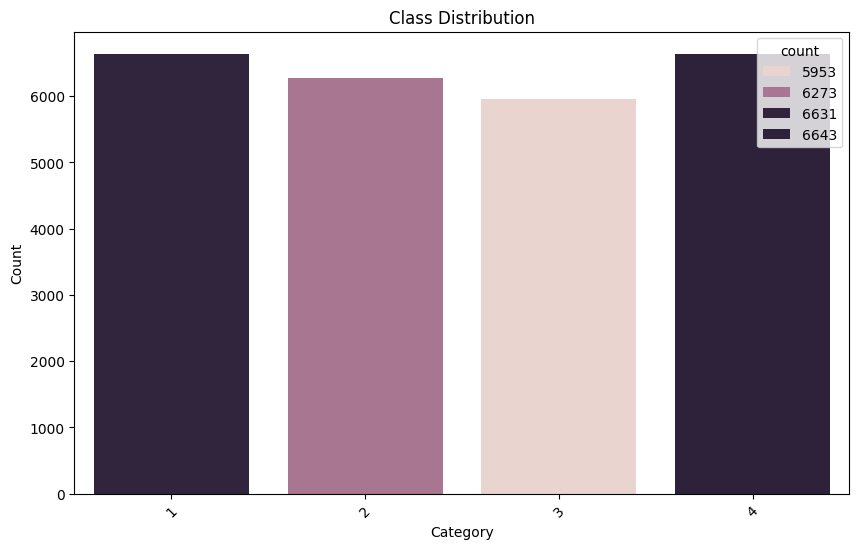

In [14]:
# Sum the counts of each index
class_counts = df_train['Class Index'].value_counts().reset_index()

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=class_counts, x='Class Index', y='count', hue='count')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Summary statistics of class distribution

class_balance = class_counts.describe()
print("Class Balance:")
print(class_balance)

Note that there is a fairly even distribution of categories in our training dataset. No further resampling techniques needed.

In [34]:
# Splitting dataframes by category

index_one = df_train['Class Index'] == 1
df_index_one = df_train[index_one]

index_two = df_train['Class Index'] == 2
df_index_two = df_train[index_two]

index_three = df_train['Class Index'] == 3
df_index_three = df_train[index_three]

index_four = df_train['Class Index'] == 4
df_index_four = df_train[index_four]

In [35]:
# Gather most common words for category World News

index_list_one = ' '.join(df_index_one['Title']).split()
word_counts_one = Counter(index_list_one)
one_common_words = word_counts_one.most_common(30)
print("\nWorld News - Most Common Words:")
print(one_common_words)


World News - Most Common Words:
[('iraq', 407), ('afp', 361), ('us', 281), ('says', 239), ('bush', 220), ('talks', 183), ('new', 177), ('najaf', 173), ('russia', 159), ('darfur', 158), ('killed', 155), ('sudan', 155), ('iraqi', 150), ('china', 146), ('bomb', 135), ('pakistan', 135), ('un', 133), ('kills', 131), ('kerry', 131), ('terror', 130), ('peace', 126), ('press', 124), ('korea', 123), ('dead', 121), ('attack', 114), ('blast', 114), ('iran', 114), ('nuclear', 112), ('canadian', 111), ('russian', 111)]


In [36]:
# Gather most common words for category Sports News

index_list_two = ' '.join(df_index_two['Title']).split()
word_counts_two = Counter(index_list_two)
two_common_words = word_counts_two.most_common(30)
print("\nSports News - Most Common Words:")
print(two_common_words)


Sports News - Most Common Words:
[('gold', 315), ('us', 261), ('win', 243), ('wins', 211), ('open', 166), ('team', 144), ('cup', 141), ('game', 119), ('olympics', 118), ('back', 112), ('sox', 112), ('olympic', 111), ('yankees', 108), ('games', 104), ('world', 102), ('new', 101), ('medal', 97), ('first', 93), ('wrap', 92), ('lead', 90), ('women', 90), ('takes', 87), ('final', 87), ('top', 86), ('athens', 85), ('beat', 83), ('england', 76), ('federer', 74), ('hewitt', 74), ('men', 71)]


In [37]:
# Gather most common words for category Business News

index_list_three = ' '.join(df_index_three['Title']).split()
word_counts_three = Counter(index_list_three)
three_common_words = word_counts_three.most_common(30)
print("\nBusiness News - Most Common Words:")
print(three_common_words)


Business News - Most Common Words:
[('oil', 489), ('us', 383), ('stocks', 305), ('update', 261), ('prices', 218), ('profit', 208), ('sales', 174), ('new', 153), ('google', 151), ('says', 145), ('rise', 128), ('shares', 128), ('dollar', 127), ('may', 121), ('deal', 120), ('higher', 115), ('fall', 112), ('cuts', 109), ('jobs', 109), ('price', 108), ('cut', 103), ('buy', 100), ('bank', 98), ('growth', 98), ('data', 97), ('talks', 93), ('airways', 90), ('opec', 83), ('china', 83), ('ipo', 83)]


In [38]:
# Gather most common words for category Sci/Tech News

index_list_four = ' '.join(df_index_four['Title']).split()
word_counts_four = Counter(index_list_four)
four_common_words = word_counts_four.most_common(30)
print("\nSci/Tech News - Most Common Words:")
print(four_common_words)


Sci/Tech News - Most Common Words:
[('new', 415), ('microsoft', 406), ('ibm', 221), ('intel', 184), ('com', 165), ('apple', 156), ('space', 150), ('internet', 141), ('windows', 141), ('linux', 138), ('software', 130), ('mobile', 125), ('phone', 121), ('oracle', 117), ('security', 113), ('web', 110), ('world', 110), ('service', 110), ('sp', 106), ('music', 105), ('pc', 104), ('google', 104), ('may', 104), ('online', 99), ('hp', 96), ('xp', 94), ('chip', 94), ('nasa', 92), ('nokia', 90), ('deal', 87)]


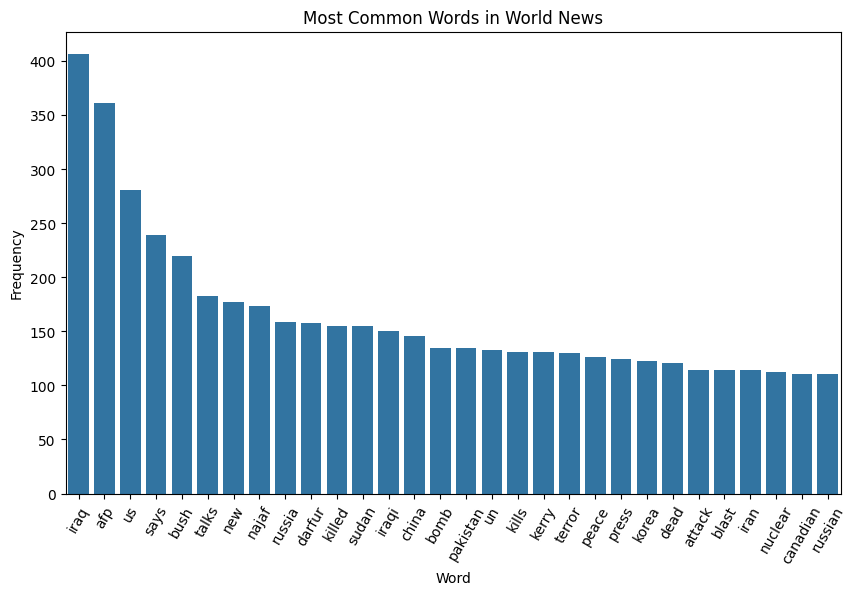

In [39]:
# Vizualize word frequency for World News

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in one_common_words], y=[word[1] for word in one_common_words])
plt.title('Most Common Words in World News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

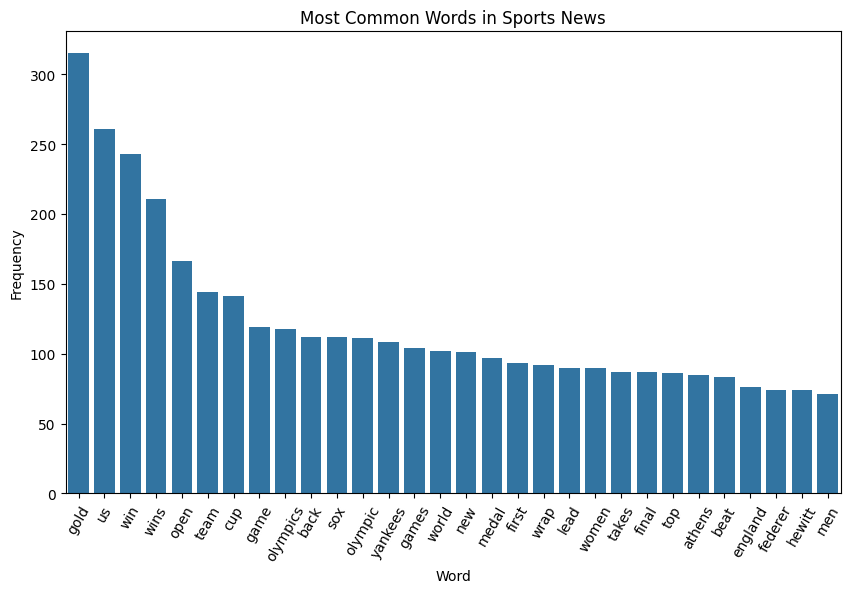

In [40]:
# Vizualize word frequency for Business News

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in two_common_words], y=[word[1] for word in two_common_words])
plt.title('Most Common Words in Sports News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

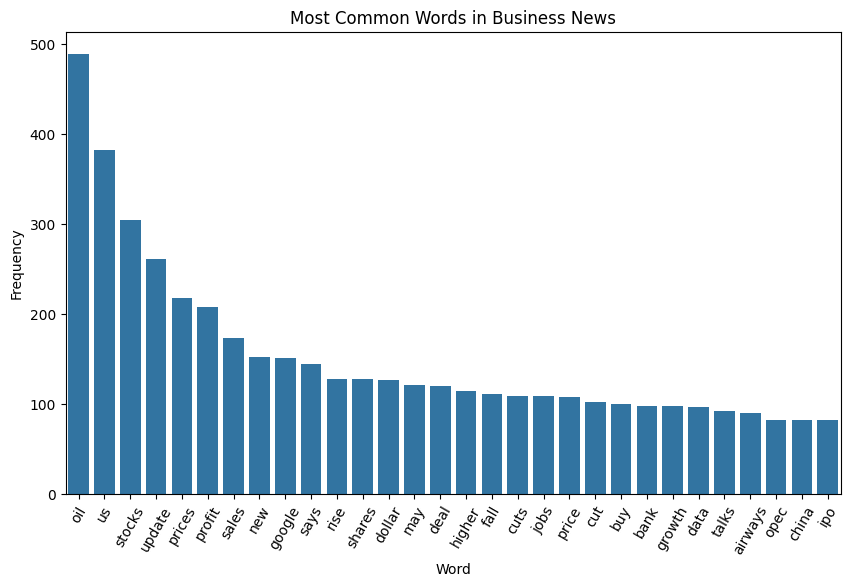

In [41]:
# Vizualize word frequency for World News

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in three_common_words], y=[word[1] for word in three_common_words])
plt.title('Most Common Words in Business News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

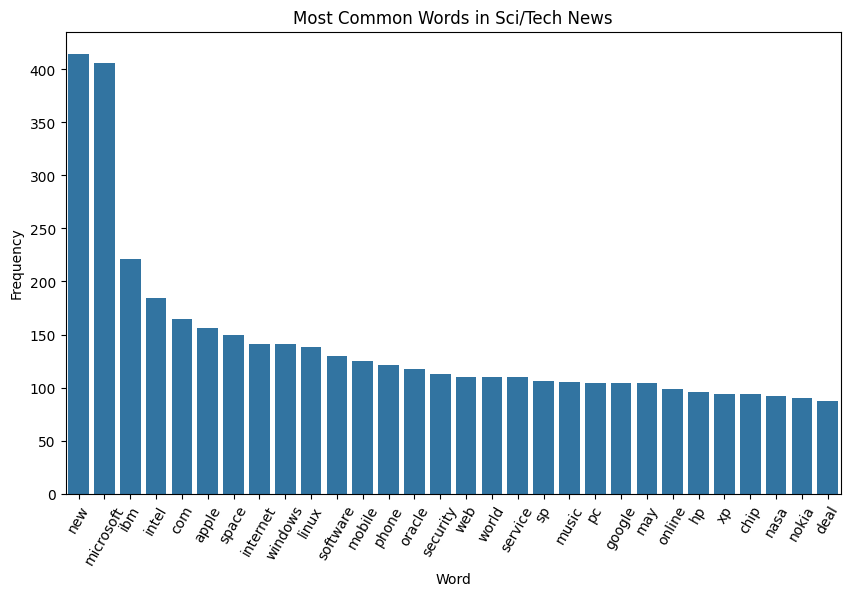

In [42]:
# Vizualize word frequency for World News

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in four_common_words], y=[word[1] for word in four_common_words])
plt.title('Most Common Words in Sci/Tech News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

In [ ]:
# Get title lengths for each row
df_train['Title Length'] = df_train['Title'].apply(lambda x: len(x.split()))
print(df_train['Title Length'])

# Modifying df_test for future use
df_test['Title Length'] = df_test['Title'].apply(lambda x: len(x.split()))

In [ ]:
# Title length analysis

plt.figure(figsize=(10, 6))
sns.histplot(df_train['Title Length'], bins=10)
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

Note that the distribution of our title lengths is right-skew

In [ ]:
#get TF IDF values as a dataframe

tfidf_df = pd.DataFrame(train_title_features.toarray())

In [ ]:
# Transform matrix to array, flatten, and removes zeros

tfidf_df = train_title_features.toarray().flatten()
tfidf_df = tfidf_df[tfidf_df != 0]

In [ ]:
# Distribution of non-zero TF-IDF Scores

sns.histplot(tfidf_df, bins=10, kde=True)
plt.xlabel("TF-IDF Score")
plt.ylabel("Number of Words")
plt.title("Distribution of TF-IDF Scores in the Corpus")
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for long feature names
plt.show()

Note that our TF IDF distribution is right skew

In [ ]:
from feature_engine.outliers import Winsorizer

In [ ]:
# Plot boxplot to find skewness

sns.boxplot(df_train['Title Length'], orient='h')
plt.xlabel("Title Length")
plt.title("Boxplot of Title Length")  # Optional: Rotate x-axis labels for long feature names
plt.show()

Confirms previous image indicating right skewness

In [ ]:
# Winsorize the text length to handle outliers

capper = Winsorizer(capping_method='gaussian', tail='right', fold=2)
capper.fit(df_train)

In [ ]:
capper.right_tail_caps_

In [ ]:
train_t = capper.transform(df_train)
test_t = capper.transform(df_test)

In [ ]:
sns.boxplot(train_t['Title Length'], orient='h')
plt.xlabel("Title Length")
plt.title("Boxplot of Title Length")  # Optional: Rotate x-axis labels for long feature names
plt.show()

Outliers are no longer present in dataset

# Transformer Model Architecture

In [160]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

In [158]:
# Positional Encoding
def get_positional_encoding(seq_length, d_model):
    positions = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    angle_rads = positions * angle_rates
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return pos_encoding


def transformer_block(x, num_heads, d_model, dff, rate, training):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(rate)(attn_output, training=training)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn_output = Dense(dff, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output, training=training)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)


# Build the Transformer Model for Text Classification
def build_model(max_len_input, vocab_size, num_heads=8, d_model=128, dff=512, rate=0.1):
    # Input
    inputs = Input(shape=(max_len_input,), name="input")
    embedding = Embedding(vocab_size, d_model, name="embedding")(inputs)
    pos_encoding = get_positional_encoding(max_len_input, d_model)
    embedding += pos_encoding

    # Transformer Encoder
    encoder_output = embedding
    for _ in range(4):
        encoder_output = transformer_block(encoder_output, num_heads, d_model, dff, rate, training=True)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(encoder_output)

    # Output layer
    outputs = Dense(1, activation="sigmoid")(pooled_output)  # Binary classification, use sigmoid activation

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])  # Binary classification, use binary_crossentropy

    return model

# Parameters
max_len_input = 100
vocab_size = 10000

# Create the model
model = build_model(max_len_input, vocab_size)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)            │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 100, 128)          │       1,280,000 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 100, 128)          │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 100, 128)          │         527,488 │ add[0][0], add[0][0]       │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 100, 128)          │               0 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 100, 128)          │               0 │ add[0][0], dropout_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 100, 128)          │             256 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 100, 512)          │          66,048 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 100, 128)          │          65,664 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 100, 128)          │               0 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 100, 128)          │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 100, 128)          │             256 │ add_2[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 100, 128)          │         527,488 │ layer_normalization_1[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 100, 128)          │               0 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 100, 128)          │               

 Total params: 3,918,977 (14.95 MB)

 Trainable params: 3,918,977 (14.95 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
def preprocess_data(input_text, tokenizer, max_len_input):
    # Tokenize input text
    input_seq = tokenizer.texts_to_sequences([input_text])

    # Pad sequences
    input_seq_padded = pad_sequences(input_seq, maxlen=max_len_input, padding='post', truncating='post')

    # Create attention mask
    attention_mask = np.where(input_seq_padded != 0, 1, 0)  # 1 where tokens are present, 0 for padding

    return input_seq_padded, attention_mask

def predict_summary(input_text, tokenizer, model, max_len_inpu, max_len_output):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq_padded, attention_mask = preprocess_data(input_text, tokenizer, max_len_input)

    # Start the decoder sequence with the start token (assuming `1` is the start token index)
    decoder_input = [1]  # Start token
    decoder_input_padded = pad_sequences([decoder_input], maxlen=max_len_output, padding='post', truncating='post')

    # Initialize the summary with empty list
    summary = []

    for _ in range(max_len_output - 1):  # We loop up to max_len_output - 1 steps
       # Predict using only input sequence tensor
       predictions = model.predict(input_seq_padded)
       print(predictions)
       next_word_id = np.argmax(predictions[0])

        # Append to summary
       summary.append(next_word_id)

       # Convert predicted indices to text
       predicted_summary = tokenizer.sequences_to_texts(predictions)

        # Print each predicted word
       predicted_word = tokenizer.index_word.get(next_word_id, '?')
       print("Predicted word:", predicted_word)

       # Add the predicted word to the sequence
       decoder_input.append(next_word_id)
       decoder_input_padded = pad_sequences([decoder_input], maxlen=max_len_output, padding='post', truncating='post')

       if next_word_id == 2:  # Assuming `2` is the end token index
            break

    predicted_summary = tokenizer.sequences_to_texts([summary])      
    return predicted_summary


max_len_output = 50  # Define the value of max_len_output as required

# Define the tokenizer
tokenizer = Tokenizer(num_words=10000)
# Fit the tokenizer on your training data or load a pre-trained tokenizer

# Example usage:
input_text = """KerasNLP is a natural language processing library that works natively with TensorFlow, JAX, or PyTorch. Built on Keras 3, these models, layers, metrics, and tokenizers can be trained and serialized in any framework and re-used in another without costly migrations.

KerasNLP supports users through their entire development cycle. Our workflows are built from modular components that have state-of-the-art preset weights when used out-of-the-box and are easily customizable when more control is needed.

This library is an extension of the core Keras API; all high-level modules are Layers or Models that receive that same level of polish as core Keras. If you are familiar with Keras, congratulations! You already understand most of KerasNLP."""
predicted_summary = predict_summary(input_text, tokenizer, model, max_len_input, max_len_output)
print("Predicted Summary:", predicted_summary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.27617082]]
Predicted word: ?
1/1 ━

In [175]:
from transformers import BertTokenizer, TFBertForTokenClassification

In [177]:
num_classes=4
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForTokenClassification.from_pretrained(model_name, num_labels=num_classes)

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [221]:
bert_train = df_train.iloc[:,0:2]
bert_test = df_test.iloc[:,0:2]
bert_train.dtypes

Class Index     int64
Title          object
dtype: object

In [251]:
test_y = bert_train.iloc[:, 0].astype('str').squeeze().tolist()
train_x = bert_train.iloc[:,1:].squeeze().tolist()
test_x = bert_test.iloc[:,:1].astype('str').squeeze().tolist()
train_y = bert_test.iloc[:,1:].squeeze().tolist()

In [282]:
token_train_y = tokenizer(train_y)
token_test_x = tokenizer(test_x)
token_train_x = tokenizer(train_x)
token_test_y = tokenizer(test_y)

In [283]:
token_train_y = token_train_y.get('input_ids')
token_test_x = token_test_x.get('input_ids')
token_train_x = token_train_x.get('input_ids')
token_test_y = token_test_y.get('input_ids')

In [304]:
def prepare_data(train_text,target_text,max_len=624):
    inputs = tokenizer(train_text, padding = 'max_length', max_length=max_len, return_tensors='tf')
    labels = tokenizer(train_text, padding = 'max_length', max_length=max_len, return_tensors='tf')

    return {
        "input_ids": inputs.input_ids,
        "attention_mask": inputs.attention_mask,
    }

In [305]:
train_data = prepare_data(train_x, train_y)
test_data = prepare_data(test_x, test_y)

In [306]:
def convert(data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.map(lambda x: {key: tf.reshape(val, [-1]) for key, val in x.items()})
    dataset = dataset.shuffle(buffer_size=5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [307]:
train_dataset = convert(train_data, 8)
test_dataset = convert(test_data, 8)

In [257]:
from keras.optimizers import SGD
from keras.losses import SparseCategoricalCrossentropy

In [258]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [267]:
epochs = 5

In [308]:
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    batch_count=0
    for batch in train_dataset:
        batch_count += 1
        print(f"Training batch {batch_count}...")
        with tf.GradientTape() as tape:
            outputs = model(**batch)
            loss_value = loss(batch["label"],outputs.logits)
            print(f"Batch {batch_count} loss: {loss_value.numpy()}")
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        tf.keras.backend.clear_session()  # Clear memory
    print(f"Completed {batch_count} batches.")

    # Evaluate on validation data
    val_loss, val_acc = model.evaluate(val_dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
# Save the fine-tuned BART model
model.save_pretrained("fine-tuned_bart_summarization")

Epoch 1/5
Training batch 1...


InvalidArgumentError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,608] = 608 is not in [0, 512) [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=tf.Tensor(shape=(8, 624), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(8, 624), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False